In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Japan_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Japan_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

1    546
0    464
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,5.0,2,2
1,2,6.0,2,3
2,2,4.0,2,1
3,2,5.0,2,5
4,2,3.0,2,5
...,...,...,...,...
1005,2,2.0,2,3
1006,2,2.0,3,5
1007,2,4.0,1,4
1008,2,5.0,2,4


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,38,21,17,15,15
2,107,123,123,130,116
3,37,44,62,70,92


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

,account_fin,fin2,fin7,mobileowner,internetaccess
0,Yes,Yes,Yes,No,No
1,Yes,Yes,Yes,Yes,Yes
2,Yes,Yes,No,Yes,Yes
3,Yes,Yes,Yes,Yes,Yes
4,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...
1005,Yes,Yes,Yes,Yes,Yes
1006,Yes,Yes,Yes,Yes,Yes
1007,Yes,Yes,Yes,Yes,Yes
1008,Yes,Yes,Yes,Yes,Yes


In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

,fin4,fin5,fin8,fin9,fin10,fin10b,fin14_1,fin14a,fin14a1,fin14b,...,fin22b,fin30,fin31a,fin31b,fin32,fin37,fin38,saved,borrowed,anydigpayment
0,Yes,No,No,Yes,Yes,No,2,No,No,No,...,No,No,NaN,NaN,No,2,Yes,1,2,1
1,No,No,No,Yes,Yes,No,2,No,No,No,...,No,Yes,Yes,No,Yes,2,Yes,2,2,1
2,Yes,No,NaN,Yes,Yes,Yes,2,No,No,No,...,No,Yes,Yes,No,Yes,2,No,1,2,1
3,Yes,Yes,Yes,Yes,Yes,Yes,1,Yes,No,Yes,...,No,Yes,Yes,No,Yes,2,No,1,1,1
4,No,No,No,Yes,Yes,Yes,2,No,No,No,...,No,Yes,Yes,No,Yes,2,No,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,Yes,Yes,Yes,Yes,Yes,Yes,2,No,No,Yes,...,No,No,NaN,NaN,Yes,2,No,2,1,1
1006,No,No,Yes,Yes,Yes,Yes,2,No,No,No,...,No,Yes,Yes,No,Yes,1,No,1,1,1
1007,Yes,Yes,No,Yes,Yes,Yes,2,No,No,No,...,No,Yes,No,No,Yes,1,No,1,2,1
1008,Yes,Yes,Yes,Yes,Yes,Yes,1,No,No,No,...,No,Yes,Yes,No,Yes,2,No,1,1,1


## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6
0,0.936696,-1.125629,1.578099,0.623783,0.284279,0.002655
1,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
2,0.151528,-0.111292,-0.448041,0.064429,-0.625422,0.003265
3,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
4,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
...,...,...,...,...,...,...
1005,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
1006,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
1007,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264
1008,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264


In [11]:
mca_u = prince.MCA(n_components=26)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC17,uPC18,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26
0,0.561323,0.030203,-0.330630,0.246984,-0.080706,0.093656,0.100425,0.192254,-0.037136,0.623011,...,-0.030530,-0.034810,0.021063,0.024481,-0.028406,-0.019389,0.004051,0.005436,0.011370,0.001798
1,0.544538,0.069022,0.330412,0.008313,-0.256453,-0.083812,-0.184563,-0.267950,-0.009315,0.393519,...,0.172223,0.026193,0.080078,0.039733,0.004101,0.021008,0.054960,-0.009483,0.008335,-0.003937
2,0.075789,-0.240994,-0.081380,-0.091596,0.058598,0.098798,-0.199544,0.053064,-0.051893,-0.051339,...,-0.142857,-0.024264,-0.159079,0.010465,-0.041739,-0.060129,0.022731,0.010879,0.000964,-0.000759
3,-0.456101,0.214932,0.389099,-0.320238,0.257481,0.116969,-0.023411,-0.171048,0.405054,0.212019,...,0.029136,-0.065591,-0.002165,0.091924,-0.030768,-0.015458,-0.084388,0.043237,0.004195,-0.013022
4,0.223453,-0.247438,-0.030898,0.162816,-0.382171,0.207454,-0.308106,-0.216479,0.078380,0.091274,...,-0.088812,-0.076602,0.058145,0.034427,0.017263,-0.005240,0.010860,-0.003532,0.007869,-0.003773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,-0.160121,0.448109,-0.142156,-0.504186,-0.111914,-0.011491,0.057780,0.058016,-0.084910,0.041377,...,0.109916,0.041122,0.050947,0.016276,0.035564,-0.057991,0.077010,-0.057801,-0.000247,-0.002128
1006,0.076261,-0.252776,-0.051417,-0.026107,-0.113544,0.148900,-0.288401,-0.092404,0.031903,-0.192910,...,-0.054594,-0.026259,0.155200,-0.113184,0.044961,0.024464,0.002262,0.011701,0.003411,0.001926
1007,-0.019952,-0.136087,0.107566,0.251614,-0.279766,0.275431,-0.372060,0.213330,-0.363994,0.292878,...,-0.145148,0.159789,0.009396,-0.080630,0.015515,0.001019,0.009962,-0.017654,0.006111,-0.009182
1008,-0.176213,-0.023843,0.259065,-0.256042,0.291870,0.306789,-0.167387,0.028278,0.396218,0.192497,...,0.018953,0.250272,0.043427,0.087738,-0.074976,0.046499,-0.039812,0.028063,0.001846,-0.007321


In [12]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,uPC1,uPC2,uPC3,uPC4,...,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,female,age,educ,inc_q
0,0.936696,-1.125629,1.578099,0.623783,0.284279,0.002655,0.561323,0.030203,-0.330630,0.246984,...,-0.028406,-0.019389,0.004051,0.005436,0.011370,0.001798,1,5.0,2,2
1,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,0.544538,0.069022,0.330412,0.008313,...,0.004101,0.021008,0.054960,-0.009483,0.008335,-0.003937,2,6.0,2,3
2,0.151528,-0.111292,-0.448041,0.064429,-0.625422,0.003265,0.075789,-0.240994,-0.081380,-0.091596,...,-0.041739,-0.060129,0.022731,0.010879,0.000964,-0.000759,2,4.0,2,1
3,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,-0.456101,0.214932,0.389099,-0.320238,...,-0.030768,-0.015458,-0.084388,0.043237,0.004195,-0.013022,2,5.0,2,5
4,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,0.223453,-0.247438,-0.030898,0.162816,...,0.017263,-0.005240,0.010860,-0.003532,0.007869,-0.003773,2,3.0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,-0.160121,0.448109,-0.142156,-0.504186,...,0.035564,-0.057991,0.077010,-0.057801,-0.000247,-0.002128,2,2.0,2,3
1006,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,0.076261,-0.252776,-0.051417,-0.026107,...,0.044961,0.024464,0.002262,0.011701,0.003411,0.001926,2,2.0,3,5
1007,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,-0.019952,-0.136087,0.107566,0.251614,...,0.015515,0.001019,0.009962,-0.017654,0.006111,-0.009182,2,4.0,1,4
1008,-0.375713,0.102105,0.072101,0.071528,0.029863,-0.001264,-0.176213,-0.023843,0.259065,-0.256042,...,-0.074976,0.046499,-0.039812,0.028063,0.001846,-0.007321,2,5.0,2,4


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

## Logistic regression

In [14]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .31, 1: .96}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.31, 1: 0.96}}
Best score: 0.9343923316355405


In [16]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9531004709576139
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        98
           1       0.85      1.00      0.92       104

    accuracy                           0.91       202
   macro avg       0.92      0.90      0.90       202
weighted avg       0.92      0.91      0.90       202



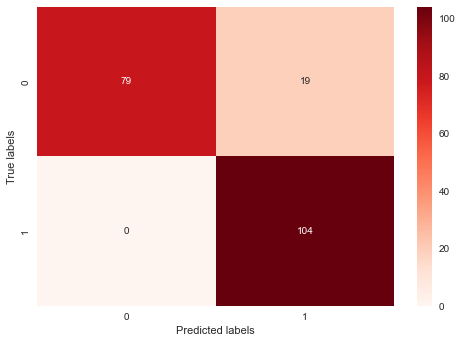

In [17]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [18]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

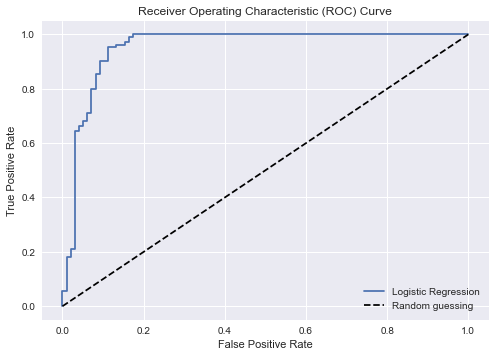

In [19]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [20]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .18, 1: .69}]
}
rf = RandomForestClassifier(random_state= 42)

In [21]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.18, 1: 0.69}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.9232105674214569


In [22]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9472135007849294
              precision    recall  f1-score   support

           0       0.95      0.77      0.85        98
           1       0.81      0.96      0.88       104

    accuracy                           0.87       202
   macro avg       0.88      0.86      0.86       202
weighted avg       0.88      0.87      0.86       202



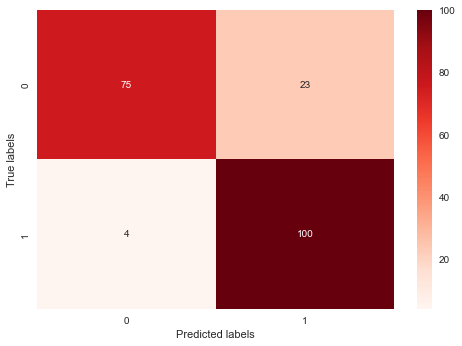

In [23]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

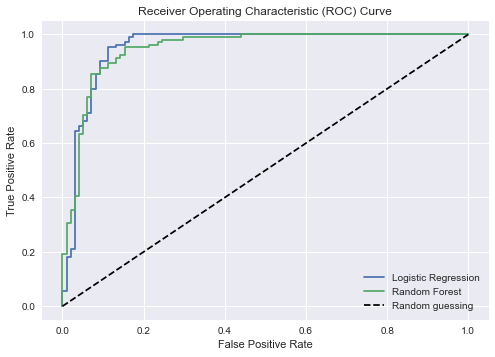

In [25]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [26]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [27]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9370099374386829


In [28]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [29]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9552590266875981
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        98
           1       0.86      0.96      0.91       104

    accuracy                           0.90       202
   macro avg       0.91      0.90      0.90       202
weighted avg       0.91      0.90      0.90       202



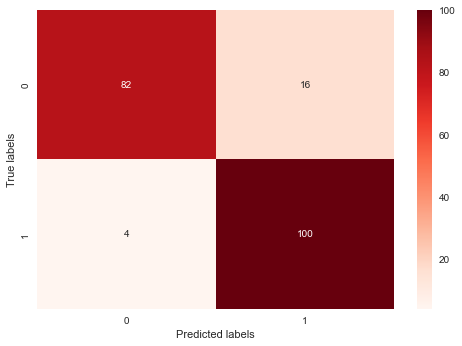

In [30]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [31]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

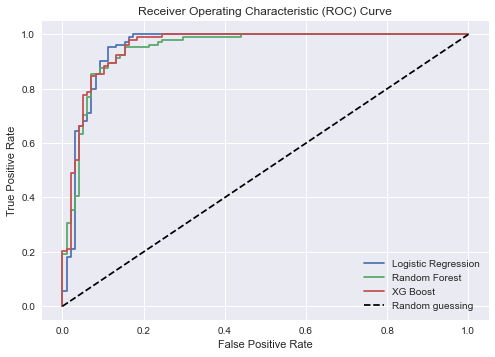

In [32]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [33]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [35]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
21/21 [==============================] - 2s 14ms/step - loss: 0.6884 - precision: 0.5640 - recall: 0.7090 - val_loss: 0.5942 - val_precision: 0.7255 - val_recall: 0.8409
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 0.5592 - precision: 0.7358 - recall: 0.9124 - val_loss: 0.4930 - val_precision: 0.8537 - val_recall: 0.7955
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4779 - precision: 0.8256 - recall: 0.8023 - val_loss: 0.4355 - val_precision: 0.7788 - val_recall: 0.9205
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4217 - precision: 0.8123 - recall: 0.8927 - val_loss: 0.3744 - val_precision: 0.8478 - val_recall: 0.8864
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.3738 - precision: 0.8431 - recall: 0.8955 - val_loss: 0.3544 - val_precision: 0.8137 - val_recall: 0.9432
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 0.3394 - precision: 0.8571 

21/21 [==============================] - 0s 3ms/step - loss: 0.0941 - precision: 0.9491 - recall: 1.0000 - val_loss: 0.2022 - val_precision: 0.9341 - val_recall: 0.9659
Epoch 47/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0943 - precision: 0.9489 - recall: 0.9972 - val_loss: 0.2057 - val_precision: 0.9341 - val_recall: 0.9659
Epoch 48/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0924 - precision: 0.9464 - recall: 0.9972 - val_loss: 0.2049 - val_precision: 0.9341 - val_recall: 0.9659
Epoch 49/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0945 - precision: 0.9491 - recall: 1.0000 - val_loss: 0.2222 - val_precision: 0.9326 - val_recall: 0.9432
Epoch 50/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0902 - precision: 0.9491 - recall: 1.0000 - val_loss: 0.2200 - val_precision: 0.9333 - val_recall: 0.9545


In [36]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [37]:
y_= y_.reshape(y_.shape[0],)

In [38]:
y_pred= np.array([round(i) for i in y_])

In [39]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9322017268445839
              precision    recall  f1-score   support

           0       0.99      0.85      0.91        98
           1       0.87      0.99      0.93       104

    accuracy                           0.92       202
   macro avg       0.93      0.92      0.92       202
weighted avg       0.93      0.92      0.92       202



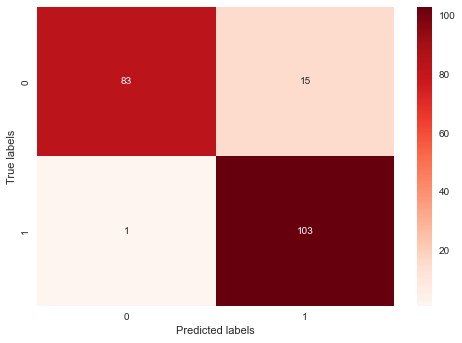

In [40]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [41]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

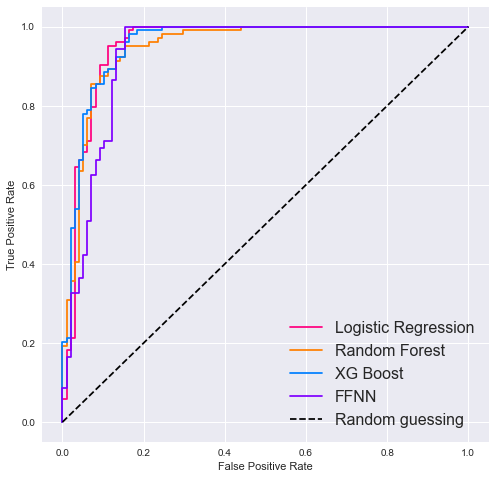

In [42]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_jap.png")
plt.show()

## Model Evaluations

In [43]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9059 & 0.8663 & 0.9010 & 0.9208 \\
   Recall & 1.0000 & 0.9615 & 0.9615 & 0.9904 \\
Precision & 0.8455 & 0.8130 & 0.8621 & 0.8729 \\
 F1-Score & 0.9163 & 0.8811 & 0.9091 & 0.9279 \\
      AUC & 0.9531 & 0.9472 & 0.9553 & 0.9322 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [44]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [45]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [46]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-0.31973591688749975, 6.792812362976406, 0.027382413565785486)

In [47]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [48]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.048803651911369116)

In [49]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.3101831664182642, 0.5915014005314202, -0.0009025639838140492)

In [50]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [51]:
IND_fin["access"] = 1- IND_fin["access"]
IND_fin["usage"] = 1- IND_fin["usage"]

In [52]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [53]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

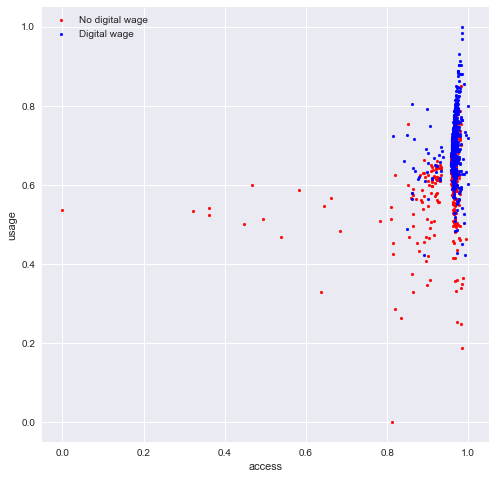

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_jap')
plt.show()

In [55]:
IND_fin['access'].describe()

count    1010.000000
mean        0.951196
std         0.063998
min         0.000000
25%         0.960074
50%         0.963459
75%         0.968240
max         1.000000
Name: access, dtype: float64

In [56]:
IND_fin['usage'].describe()

count    1010.000000
mean        0.656997
std         0.096265
min         0.000000
25%         0.617376
50%         0.656630
75%         0.715641
max         1.000000
Name: usage, dtype: float64

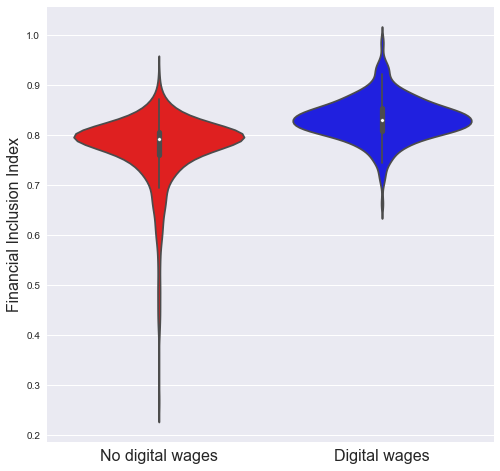

In [57]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_jap')

# Show the plot
plt.show()

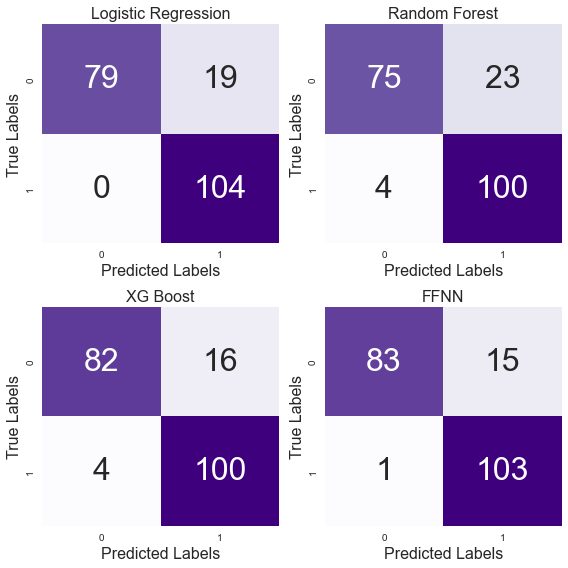

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices


for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Purples", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_jap.png')
# Display the plot
plt.show()

## Feature Importance

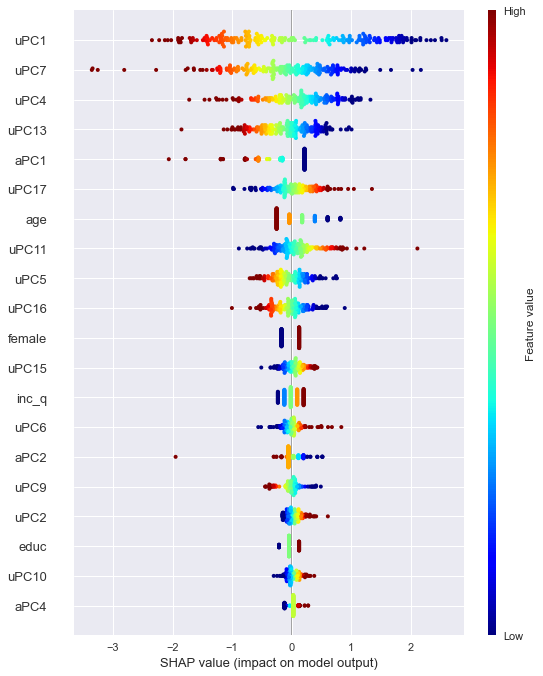

In [67]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [60]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

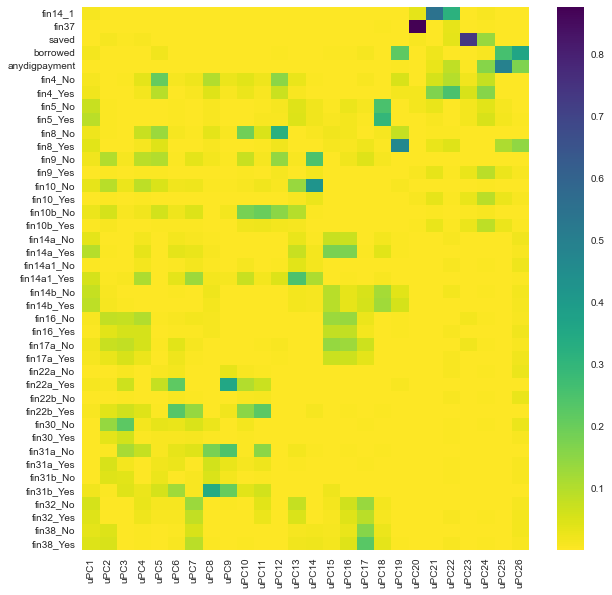

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_jap.png')
plt.show()

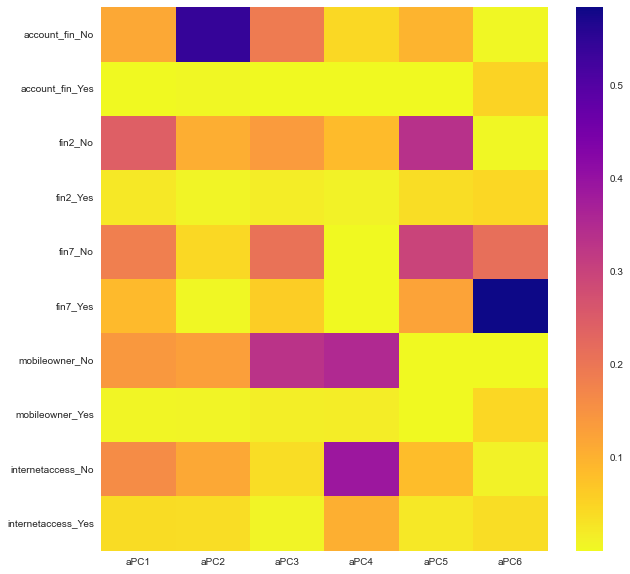

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_jap.png')
plt.show()

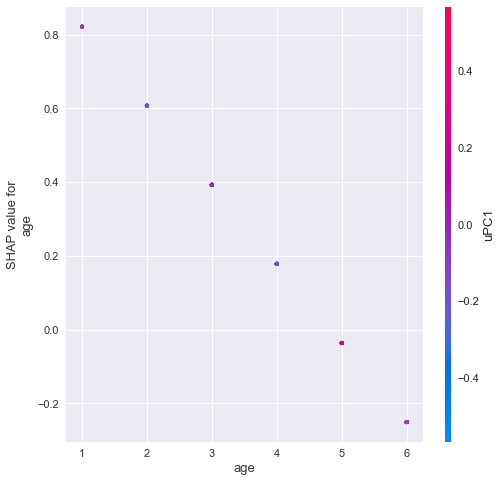

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

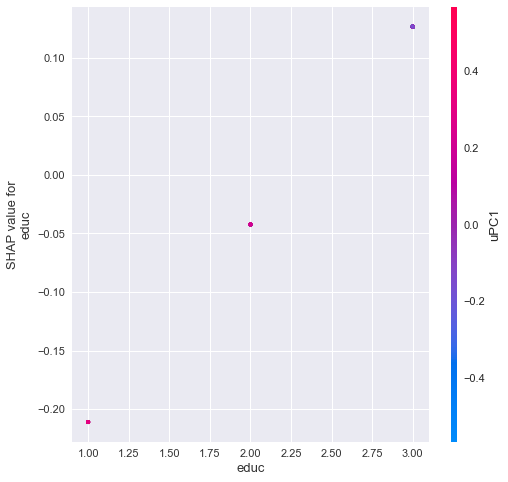

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

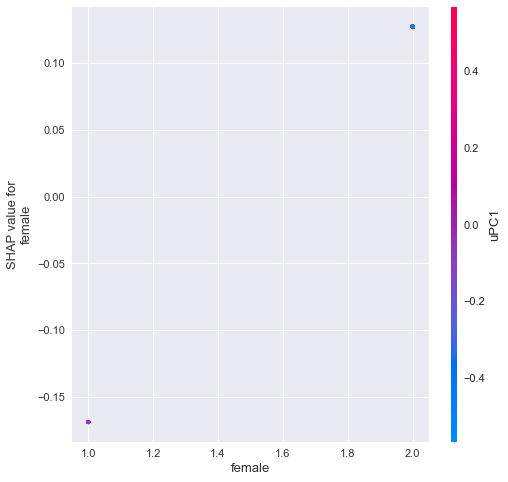

In [65]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

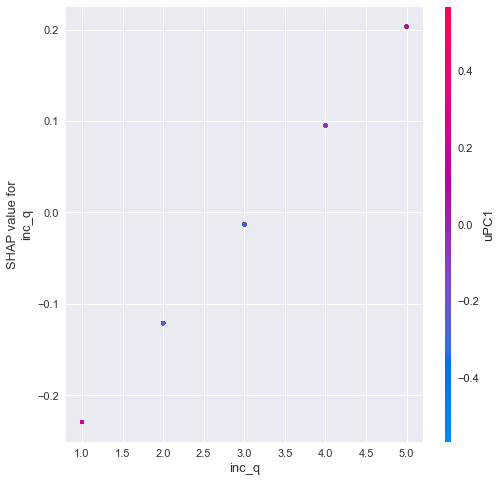

In [66]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()